
###### HUMAN DATA ANALYTICS EXAM
Done by :    - Norhen Abdennadher , ID : 2058386
             - Achraf Sahnoun , ID : 2058388

Professors : - Professor Michele Rossi
             - Professor Francesca Meneghello



# Detecting arrythmia using Deep Leaning

Installing required libraries

In [ ]:
!pip install wfdb

     |████████████████████████████████| 137 kB 5.0 MB/s 
     |████████████████████████████████| 11.2 MB 64.6 MB/s 
     |████████████████████████████████| 895 kB 55.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.1
     |████████████████████████████████| 13.1 MB 5.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires m

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=82c4794f126bb1417acea2bf0207755cdcab52885183b6a2585ab515ceaecf34
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


Import required modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from os import listdir
import wfdb
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
import wget
from zipfile import ZipFile




## Download MIT BIH Arrythmia Dataset

In [ ]:
import zipfile

#Path of the dataset zip file
database_path = "/content/mit-bih-arrhythmia-database-1.0.0.zip"
 
with zipfile.ZipFile(database_path, 'r') as zip_ref:
   zip_ref.extractall(".")

## Loading data

Loading list of records available, from dataset available [here](https://physionet.org/content/mitdb/1.0.0/)

In [ ]:
#RECORDS file contains the name of the records corresponding to the subjects of the MIT BIH dataset
records = np.loadtxt("/content/mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

Defining invalid beats as well as abnormal beats, according to [Physiobank](https://archive.physionet.org/physiobank/annotations.shtml)

In [ ]:
#The standard set of annotation codes was originally defined for ECGs, and includes both beat annotations and non-beat annotations. 
#Invalid beats are beats that will be discarded from the dataset
invalid_beats = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]
#abnormal beats are beats with different types of anomalies
abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]

##Data exploration

In [ ]:
#Path of extracted dataset
dataset_path = 'mit-bih-arrhythmia-database-1.0.0/'
# list of patients
patients = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [ ]:
df = pd.DataFrame()
#we will load all the annotations in order to see the distribution of heart beat types across all files.
for pt in patients:
    file = dataset_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [ ]:
df.groupby('sym').val.sum().sort_values(ascending = False)


sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [ ]:
#The following function will be useful for loading a single patient's signals and annotations. 
def load_ecg(file):
    # The example of file: '/content/mit-bih-arrhythmia-database-1.0.0/101'
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    # extract the signal
    p_signal = record.p_signal
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    # extraction of the symbols and annotation index
    atr_symbols = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_symbols, atr_sample 

In [ ]:
#Let's check out what abnormal beats are in a patient's ecg:
file = dataset_path + patients[5]
p_signal, atr_symbols, atr_sample = load_ecg(file)
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [ ]:
# get abnormal beat index
abnormal_index = [b for a,b in zip(atr_symbols,atr_sample) if a in abnormal_beats][:10]
abnormal_index
x = np.arange(len(p_signal))

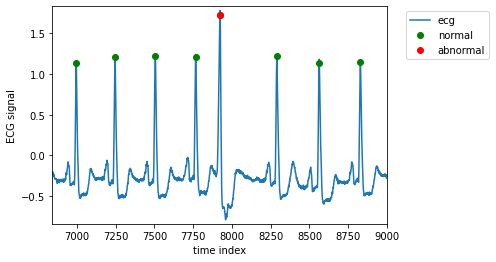

In [ ]:
left = abnormal_index[1]-1080
right = abnormal_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[abnormal_index],p_signal[abnormal_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

## Processing dataset

In [ ]:
#This function classify a beat according to its symbol and the list provided above.
#This function classifies a beat into normal (0) or abnormal heartbeats (1)
#Normal beat (displayed as "·" by the PhysioBank ATM, LightWAVE, pschart, and psfd)
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0    

Given a signal, the beat location, and the window to be used as a sequence, this function gets the sequence. It will return an empty array in case of an invalid beat or empty sequence.

In [ ]:
#This function takes as argument the original signal, the location of the heartbeat, window size in seconds and the sampling frequency
def get_sequence(signal, beat_location, window_sec, fs):
    window_one_side = window_sec * fs
    beat_begin = beat_location - window_one_side
    beat_end = beat_location + window_one_side
    if beat_end < signal.shape[0]: #make sure the beat's end doesn't exceed the length of the signal
        sequence = signal[beat_begin:beat_end, 0] #the signal is composed by two channels, we take the first one 'MLII'
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([]) #else return an empty sequence

The code below will build a list of labels and sequences as well as map the sequences for each patient. The percentage calculated represents the ratio of abnormal beats in each patient data.

In [ ]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
#iterate over the different records 
for subject in records:
    #read record for subject x
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
    #read annotation file for subject x
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    #atr_symbol contains the annotation of each beat (normal or PVC or ...)
    atr_symbol = annotation.symbol
    #atr_sample contains the location of the R position in the dataset
    atr_sample = annotation.sample
    #sampling frequency
    fs = record.fs
    #standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    #standardize the signal
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    #enumerate over the location of the beats, i is the index and i_sample is the location
    for i, i_sample in enumerate(atr_sample):
        #classify the symbol into normal and abnormal, if normal 0, if abnormal 1, else None
        label = classify_beat(atr_symbol[i])
        #get the sequence related to that heartbeat
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        #verify that the beat is valid and the sequence is not empty
        if label is not None and sequence.size > 0:
            #append the sequences in one ssequence for the same record
            all_sequences.append(sequence)
            #subject labels contains labels for the subject
            subject_labels.append(label)
    #the percentage of normal beats
    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)
    #after executing this cell, all sequences will contain all sequences and all labels for each subjects

In [ ]:
subject_map

[{'end': 2264,
  'num_seq': 2264,
  'percentage': 0.015017667844522967,
  'start': 0,
  'subject': 100},
 {'end': 4122,
  'num_seq': 1858,
  'percentage': 0.002691065662002153,
  'start': 2264,
  'subject': 101},
 {'end': 6301,
  'num_seq': 2179,
  'percentage': 0.9545663148233134,
  'start': 4122,
  'subject': 102},
 {'end': 8379,
  'num_seq': 2078,
  'percentage': 0.0009624639076034649,
  'start': 6301,
  'subject': 103},
 {'end': 10600,
  'num_seq': 2221,
  'percentage': 0.9266096352994146,
  'start': 8379,
  'subject': 104},
 {'end': 13164,
  'num_seq': 2564,
  'percentage': 0.01794071762870515,
  'start': 10600,
  'subject': 105},
 {'end': 15185,
  'num_seq': 2021,
  'percentage': 0.25630875804057396,
  'start': 13164,
  'subject': 106},
 {'end': 17315,
  'num_seq': 2130,
  'percentage': 1.0,
  'start': 15185,
  'subject': 107},
 {'end': 19072,
  'num_seq': 1757,
  'percentage': 0.013659647125782584,
  'start': 17315,
  'subject': 108},
 {'end': 21595,
  'num_seq': 2523,
  'percen

Creating bins to be used to stratify the train and validation split. 

In [ ]:
subject_map = pd.DataFrame(subject_map)
subject_map

,subject,percentage,num_seq,start,end
0,100,0.015018,2264,0,2264
1,101,0.002691,1858,2264,4122
2,102,0.954566,2179,4122,6301
3,103,0.000962,2078,6301,8379
4,104,0.926610,2221,8379,10600
5,105,0.017941,2564,10600,13164
6,106,0.256309,2021,13164,15185
7,107,1.000000,2130,15185,17315
8,108,0.013660,1757,17315,19072
9,109,1.000000,2523,19072,21595


The code presented will create class in each patient is segmented.

In [ ]:
#segment data according to the percentage of abnormalities, intervals are shown in bins [0,0.2], [0.2,0.6],[0.6,1]

bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

Now, the dataset is split into train and validation, stratifying by the bin defined above.

In [ ]:
#This stratify parameter makes a split so that the proportion of values in the sample produced
#will be the same as the proportion of values provided to parameter stratify
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)
#if record comtains a percentage between 0 and 0.2 it's bin value is 0, if it's between 0.2 and 0.6 it's bin value is 1, if between 0.6 and 1
#the bin value will be 2
#The stratified split will impose the existence of the same proportion of bins between both sets which means same proprtion of normality and abnormality

In [ ]:
validation

,subject,percentage,num_seq,start,end,bin
7,107,1.000000,2130,15185,17315,2
44,231,0.799361,1565,99978,101543,2
30,209,0.128128,2997,64581,67578,0
33,213,0.188330,3239,72958,76197,0
12,113,0.003356,1788,26244,28032,0
22,124,1.000000,1614,45871,47485,2
16,117,0.000654,1529,34255,35784,0
24,201,0.172713,1957,50078,52035,0
18,119,0.223624,1981,38055,40036,1
31,210,0.085227,2640,67578,70218,0


This function build a dataset based on the map for each split.

In [ ]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        begin = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[begin:end])
        labels.extend(all_labels[begin:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [ ]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [ ]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

In [ ]:
X_val.shape, y_val.shape

((26259, 2160, 1), (26259, 1))

## Training the model

### CNN model

In [ ]:
######### zedt batchnorm, dropout, early stopping w save best model
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, Flatten, Dense, Dropout,MaxPool1D
from tensorflow.keras.optimizers import Adam

sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential([
    Conv1D(filters=16,kernel_size=4,strides=1,input_shape=(sequence_size, n_features),padding="same",activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Conv1D(filters=8,kernel_size=4,strides=1,padding="same",activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Flatten(),
    Dense(32,activation="sigmoid"),
    Dropout(0.3),
    Dense(1,activation="sigmoid",name="output")
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2160, 16)          80        
                                                                 
 batch_normalization (BatchN  (None, 2160, 16)         64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2160, 16)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2160, 8)           520       
                                                                 
 batch_normalization_1 (Batc  (None, 2160, 8)          32        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 2160, 8)           0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
######### fazet
import tensorflow as tf 
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_CNN_model.h5', monitor='val_loss', save_best_only=True)]

hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=64,
    callbacks=callbacks,
    epochs=20,
    validation_data=(X_val, y_val)
) 

Epoch 1/20
1295/1295 [==============================] - 242s 184ms/step - loss: 0.1679 - accuracy: 0.9383 - val_loss: 0.5965 - val_accuracy: 0.8139
Epoch 2/20
1295/1295 [==============================] - 243s 187ms/step - loss: 0.1120 - accuracy: 0.9620 - val_loss: 0.5726 - val_accuracy: 0.8490
Epoch 3/20
1295/1295 [==============================] - 244s 188ms/step - loss: 0.0956 - accuracy: 0.9677 - val_loss: 0.5769 - val_accuracy: 0.8453
Epoch 4/20
1295/1295 [==============================] - 240s 185ms/step - loss: 0.0889 - accuracy: 0.9690 - val_loss: 0.5156 - val_accuracy: 0.8594
Epoch 5/20
1295/1295 [==============================] - 239s 185ms/step - loss: 0.0832 - accuracy: 0.9712 - val_loss: 0.5593 - val_accuracy: 0.8549
Epoch 6/20
1295/1295 [==============================] - 239s 184ms/step - loss: 0.0794 - accuracy: 0.9724 - val_loss: 0.5715 - val_accuracy: 0.8491
Epoch 7/20
1295/1295 [==============================] - 238s 183ms/step - loss: 0.0746 - accuracy: 0.9738 - val_

In [ ]:
model = tf.keras.models.load_model('/content/best_CNN_model.h5')
model.evaluate(X_val, y_val)

821/821 [==============================] - 17s 21ms/step - loss: 0.5156 - accuracy: 0.8594


[0.5155589580535889, 0.8594005703926086]

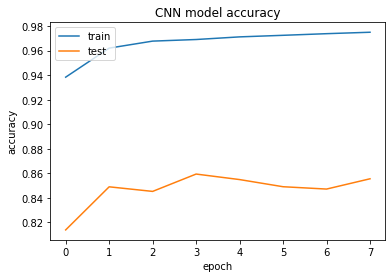

In [ ]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

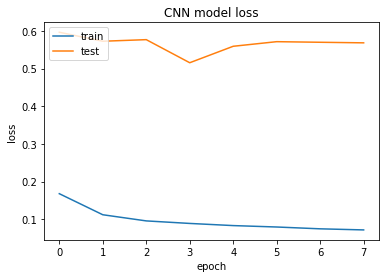

In [ ]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN with LSTM model

In [ ]:
sequence_size = X_train.shape[1]
n_features = 1 
n_subsequences = 4
subsequence_size = int(sequence_size / n_subsequences)

# Reshaping to be (samples, subsequences, sequence, feature)
X_train = X_train.reshape(-1, n_subsequences, subsequence_size, n_features)
X_val = X_val.reshape(-1, n_subsequences, subsequence_size, n_features)

In [ ]:
############### tbadel li mel loutaaa omour model ka mouhawla oula

In [ ]:
from keras.layers import Conv1D,BatchNormalization, Flatten, Dense, Dropout,MaxPool1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(learn_rate):
  cnn_lstm_model = Sequential([
    TimeDistributed(
        Conv1D(
            filters=16,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu"
        ), 
        input_shape=(n_subsequences, subsequence_size, n_features)
    ),
    BatchNormalization(),
    Dropout(0.3),
    TimeDistributed(Conv1D(filters=8,kernel_size=4,strides=1,padding="same",activation="relu")),
    BatchNormalization(),
    Dropout(0.3),
    TimeDistributed(Flatten()),
    LSTM(units=8,activation="tanh"),
    Dropout(0.3),

    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
    ])
  callbacks = [EarlyStopping(monitor='val_loss', patience=8),
  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

  optimizer = Adam(lr=learn_rate)
  # Compiling the model
  cnn_lstm_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
   )
  return cnn_lstm_model
  

learn_rate = [0.001, 0.01]
batch_size = [32,64]
param_grid = dict(learn_rate=learn_rate, batch_size=batch_size)
model = KerasClassifier(build_fn=create_model, epochs=5, verbose=0)

grid = GridSearchCV(estimator=model, scoring="accuracy",param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best: 0.830524 using {'batch_size': 64, 'learn_rate': 0.001}


In [ ]:
from keras.layers import Conv1D,BatchNormalization, Flatten, Dense, Dropout,MaxPool1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
train_params = {
    "batch_size": 64,
    "epochs": 20,
    "verbose": 1,
    "validation_data": (X_val, y_val),
}

cnn_lstm_model = Sequential([
    TimeDistributed(
        Conv1D(
            filters=16,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu"
        ), 
        input_shape=(n_subsequences, subsequence_size, n_features)
    ),
    BatchNormalization(),
    Dropout(0.3),
    TimeDistributed(Conv1D(filters=8,kernel_size=4,strides=1,padding="same",activation="relu")),
    BatchNormalization(),
    Dropout(0.3),
    TimeDistributed(Flatten()),
    LSTM(units=8,activation="tanh"),
    Dropout(0.3),

    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
    ])
callbacks = [EarlyStopping(monitor='val_loss', patience=8),
ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
optimizer = Adam(lr=0.001)
# Compiling the model
cnn_lstm_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train,callbacks=callbacks,**train_params)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
1295/1295 [==============================] - 243s 183ms/step - loss: 0.2319 - accuracy: 0.9113 - val_loss: 0.6576 - val_accuracy: 0.7793
Epoch 2/20
1295/1295 [==============================] - 237s 183ms/step - loss: 0.1492 - accuracy: 0.9485 - val_loss: 0.6043 - val_accuracy: 0.8006
Epoch 3/20
1295/1295 [==============================] - 237s 183ms/step - loss: 0.1314 - accuracy: 0.9549 - val_loss: 0.6667 - val_accuracy: 0.8049
Epoch 4/20
1295/1295 [==============================] - 234s 181ms/step - loss: 0.1205 - accuracy: 0.9589 - val_loss: 0.5663 - val_accuracy: 0.7939
Epoch 5/20
1295/1295 [==============================] - 234s 181ms/step - loss: 0.1117 - accuracy: 0.9631 - val_loss: 0.5647 - val_accuracy: 0.8300
Epoch 6/20
1295/1295 [==============================] - 238s 184ms/step - loss: 0.1060 - accuracy: 0.9633 - val_loss: 0.5749 - val_accuracy: 0.8178
Epoch 7/20
1295/1295 [==============================] - 240s 186ms/step - loss: 0.1008 - accuracy: 0.9659 - val_

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/best_model.h5')
model.evaluate(X_val, y_val)

821/821 [==============================] - 23s 26ms/step - loss: 0.5647 - accuracy: 0.8300


[0.5647323727607727, 0.8299630880355835]

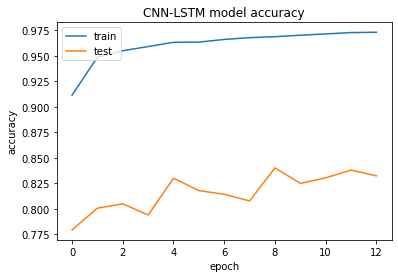

In [ ]:
# summarize history for accuracy
plt.plot(history_cnn_lstm.history['accuracy'])
plt.plot(history_cnn_lstm.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

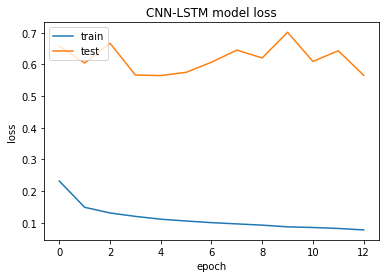

In [ ]:
# summarize history for loss
plt.plot(history_cnn_lstm.history['loss'])
plt.plot(history_cnn_lstm.history['val_loss'])
plt.title('CNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### ***Personalized learning***

In [ ]:
all_sequences = []
all_labels = []
window_size = 300 #size of the window corresponds to 300 sample which corresponds approximately to 1 single heartbeat 
subject_map = []
for subject in [202,201]: #iterate over the different records 
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}') #read record for subject x
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr') #read annotation file for subject x
    atr_symbol = annotation.symbol #atr_symbol contains the annotation of each beat (normal or PVC or ...)
    atr_sample = annotation.sample #atr_sample contains the location of the R position in the dataset
    fs = record.fs #sampling frequency
    scaler = StandardScaler() #standardize features by removing the mean and scaling to unit variance
    signal = scaler.fit_transform(record.p_signal) #standardize the signal
    subject_labels = []
    for i, i_sample in enumerate(atr_sample): #enumerate over the location of the beats, i is the index and i_sample is the location
        label = classify_beat(atr_symbol[i]) #classify the symbol into normal and abnormal, if normal 0, if abnormal 1, else None
        sequence = get_sequence(signal, i_sample, window_size, fs) #get the sequence related to that heartbeat
        if label is not None and sequence.size > 0: #verify that the beat is valid and the sequence is not empty
            all_sequences.append(sequence) #append the sequences in one ssequence for the same record
            subject_labels.append(label) #subject labels contains labels for the subject
    abnormal_percentage = sum(subject_labels) / len(subject_labels) #the percentage of normal beats
    abnormal_number= sum(subject_labels)
    normal_number=len(subject_labels)-abnormal_number
    subject_map.append({
        "subject": subject,
        "percentage": abnormal_percentage,
        "n° normal beats":normal_number,
        "n° abnormal beats": abnormal_number,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)
#after executing this cell, all sequences will contain all sequences and all labels for each subjects

In [ ]:
subject_map = pd.DataFrame(subject_map)

In [ ]:
subject_map

,subject,percentage,n° normal beats,n° abnormal beats,num_seq,start,end
0,202,0.035129,2060,75,2135,0,2135
1,201,0.172185,1625,338,1963,2135,4098


In [ ]:
#segment data according to the percentage of abnormalities, intervals are shown in bins [0,0.2], [0.2,0.6],[0.6,1]
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

In [ ]:
subject_map

,subject,percentage,n° normal beats,n° abnormal beats,num_seq,start,end,bin
0,202,0.035129,2060,75,2135,0,2135,0
1,201,0.172185,1625,338,1963,2135,4098,0


In [ ]:
#This stratify parameter makes a split so that the proportion of values in the sample produced
#will be the same as the proportion of values provided to parameter stratify
train, validation = train_test_split(subject_map, test_size=0.2, stratify=subject_map["bin"], random_state=42)
#stratify=subject_map["bin"],
#if record comtains a percentage between 0 and 0.2 it's bin value is 0, if it's between 0.2 and 0.6 it's bin value is 1, if between 0.6 and 1
#the bin value will be 2
#The stratified split will impose the existence of the same proportion of bins between both sets which means same proprtion of normality and abnormality

In [ ]:
#This function build a dataset based on the map for each split
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        begin = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[begin:end])
        labels.extend(all_labels[begin:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [ ]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

### CNN model

Import modules

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers

In [ ]:
sequence_size = X_train.shape[1]
n_features = 1
#Define the architecture of the CNN network 
cnn_model = Sequential([
    Conv1D(
        filters=2,
        kernel_size=4,
        strides=1,
        input_shape=(sequence_size, n_features),
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l=0.01)
    ),
    Flatten(),
    Dropout(0.7),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(0.01)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 300, 2)            10        
                                                                 
 flatten_3 (Flatten)         (None, 600)               0         
                                                                 
 dropout_2 (Dropout)         (None, 600)               0         
                                                                 
 output (Dense)              (None, 1)                 601       
                                                                 
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=15,
    validation_data=(X_val, y_val)
) 

Epoch 1/15
16/16 [==============================] - 1s 30ms/step - loss: 0.4473 - accuracy: 0.8299 - val_loss: 0.2158 - val_accuracy: 0.9686
Epoch 2/15
16/16 [==============================] - 0s 17ms/step - loss: 0.2740 - accuracy: 0.9328 - val_loss: 0.1492 - val_accuracy: 0.9752
Epoch 3/15
16/16 [==============================] - 0s 17ms/step - loss: 0.2085 - accuracy: 0.9480 - val_loss: 0.1252 - val_accuracy: 0.9766
Epoch 4/15
16/16 [==============================] - 0s 15ms/step - loss: 0.1864 - accuracy: 0.9506 - val_loss: 0.1376 - val_accuracy: 0.9738
Epoch 5/15
16/16 [==============================] - 0s 17ms/step - loss: 0.1877 - accuracy: 0.9480 - val_loss: 0.1806 - val_accuracy: 0.9625
Epoch 6/15
16/16 [==============================] - 0s 16ms/step - loss: 0.1745 - accuracy: 0.9562 - val_loss: 0.1284 - val_accuracy: 0.9775
Epoch 7/15
16/16 [==============================] - 0s 16ms/step - loss: 0.1618 - accuracy: 0.9608 - val_loss: 0.1233 - val_accuracy: 0.9789
Epoch 8/15
16

In [ ]:
cnn_model.evaluate(X_val, y_val)

67/67 [==============================] - 0s 3ms/step - loss: 0.1216 - accuracy: 0.9785


[0.12158545851707458, 0.9784543514251709]

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.1.3
Uninstalling matplotlib-3.1.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.1.3
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb

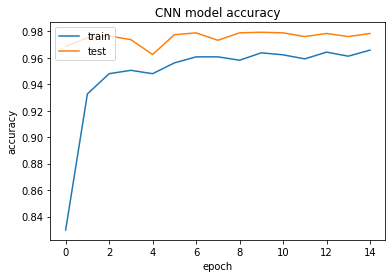

In [ ]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

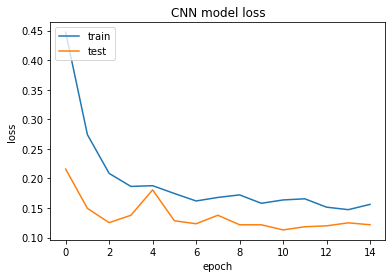

In [ ]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN with LSTM model

In [ ]:
sequence_size = X_train.shape[1]
n_features = 1 
n_subsequences = 4
subsequence_size = int(sequence_size / n_subsequences)

# Reshaping to be (samples, subsequences, sequence, feature)
X_train = X_train.reshape(-1, n_subsequences, subsequence_size, n_features)
X_val = X_val.reshape(-1, n_subsequences, subsequence_size, n_features)

In [ ]:
cnn_lstm_model = Sequential([
    TimeDistributed(
        Conv1D(
            filters=8,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu"
        ), 
        input_shape=(n_subsequences, subsequence_size, n_features)
    ),
    TimeDistributed(Flatten()),
    LSTM(units=4),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_lstm_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 4, 75, 8)         40        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 4, 600)           0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 9680      
                                                                 
 output (Dense)              (None, 1)                 5         
                                                                 
Total params: 9,725
Trainable params: 9,725
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_params = {
    "batch_size": 64,
    "epochs": 15,
    "verbose": 1,
    "validation_data": (X_val, y_val),
}

history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, **train_params)

Epoch 1/15
31/31 [==============================] - 4s 34ms/step - loss: 0.4766 - accuracy: 0.8095 - val_loss: 0.2550 - val_accuracy: 0.9653
Epoch 2/15
31/31 [==============================] - 1s 26ms/step - loss: 0.2368 - accuracy: 0.9358 - val_loss: 0.1805 - val_accuracy: 0.9630
Epoch 3/15
31/31 [==============================] - 1s 28ms/step - loss: 0.1673 - accuracy: 0.9536 - val_loss: 0.1497 - val_accuracy: 0.9663
Epoch 4/15
31/31 [==============================] - 1s 29ms/step - loss: 0.1344 - accuracy: 0.9674 - val_loss: 0.1273 - val_accuracy: 0.9705
Epoch 5/15
31/31 [==============================] - 1s 31ms/step - loss: 0.1222 - accuracy: 0.9705 - val_loss: 0.1272 - val_accuracy: 0.9691
Epoch 6/15
31/31 [==============================] - 1s 31ms/step - loss: 0.1149 - accuracy: 0.9710 - val_loss: 0.1196 - val_accuracy: 0.9705
Epoch 7/15
31/31 [==============================] - 1s 29ms/step - loss: 0.1095 - accuracy: 0.9725 - val_loss: 0.1216 - val_accuracy: 0.9677
Epoch 8/15
31

In [ ]:
cnn_lstm_model.evaluate(X_val, y_val)

67/67 [==============================] - 0s 6ms/step - loss: 0.1067 - accuracy: 0.9691


[0.10666579753160477, 0.9690866470336914]

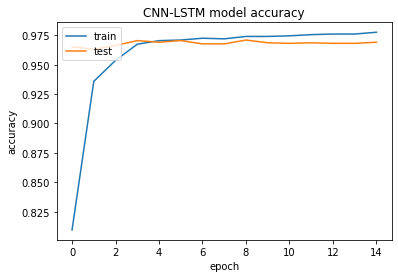

In [ ]:
# summarize history for accuracy
plt.plot(history_cnn_lstm.history['accuracy'])
plt.plot(history_cnn_lstm.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

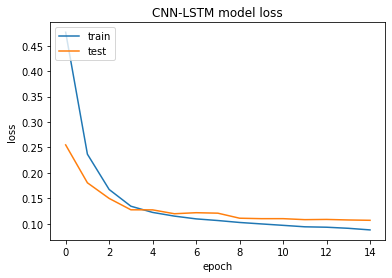

In [ ]:
# summarize history for loss
plt.plot(history_cnn_lstm.history['loss'])
plt.plot(history_cnn_lstm.history['val_loss'])
plt.title('CNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()